In [1]:
############--- Install & import python packages ---############
import numpy as np
import pandas as pd
import os
from datetime import datetime, date
import time
import traceback
import yfinance as yf
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore", category=UserWarning)

############--- fbprophet packages ---############
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import add_changepoints_to_plot
import altair as alt
from fbprophet.plot import plot_plotly
import plotly.offline as py

############--- ARIMA packages ---############
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

############--- Google colab packages ---############
# import io
# import google.colab 

############--- easyprophet package ---############
# !pip install easyprophet
from easyprophet import easyprophet

# Display multiple outputs without the need of print()
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 1 Set-up parameters to read/write files, and import the input file

In [19]:
############--- Parameters for input file ---#########
input_f = "NIO.csv"               # Name of the input file
date_var = "Date"                  # Name of the Date variable in the input file (e.g. Date)
y_var = "Close"                      # Name of the colum containing the y variable in the input file
aggr_f = False                      # aggregation function used to aggregate the initial df (e.g. {"var1":['count']})

############--- Parameters for prophet modeling ---#########
freq_period = 7
future_pred_period = 30       # N° of periods (hours/days/months) to predict in the future. False for no future predictions (default=False)
freq_data = "D"              # Frequency of the data, and of the period to be predicted (pd.date_range format: 'H':hourly, 'D':Daily, 'M':Monthly)
growth="linear"               # linear or logistic trend. If logistic you need to provide cap and floor of your predictions as well as historic data (default="linear")
cap=None                      # Name of the column containing the carrying capacity, i.e. the saturating maximum (must be specified for every row in the df).
floor=None                    # Name of the column containing the floor (saturating minimum). To use a logistic growth trend with a saturating minimum, a maximum capacity must also be specified.
yearly_seasonality = True     # Whether to include yearly seasonality. Can be 'auto', True, False (default="auto")
weekly_seasonality = True     # Whether to include weekly seasonality. Can be 'auto', True, False (default="auto")
daily_seasonality = False     # Whether to include daily seasonality. Can be 'auto', True, False (default="auto")
custom_seasonality = False    # List, containing custom seasonality's [name, freq_period in a year, fourier_order] (e.g ["Quarterly", (365.25/4), 10]
seasonality_mode ="additive"  # 'additive' or 'multiplicative' (default="additive")
seasonality_prior_scale=15.0  # strength of the seasonality model. larger values => larger seasonal fluctuations (default=10.0)
holidays_prior_scale=10.0     # strength of the holiday components model (default=10.0)
holidays_country="US"         # name of the country of which load standard holidays (e.g. "US"), False for nothing (default=False)
interval_width=0.90           # Float, width of the uncertainty intervals provided for the forecast (default=0.80)
changepoints=None             # List of dates at which to include potential changepoints (default=None)
n_changepoints=25             # Number of potential changepoints to include. Not used if input `changepoints` is supplied (default=25)
changepoint_range=0.95        # Proportion of history in which trend changepoints will be estimated (default=0.80)
changepoint_prior_scale=0.10  # Flexibility of automatic changepoint selection & consequently of the trend. Increase it to make the trend more flexible (default=0.05) 

############--- Parameters for prophet cross-validation ---#########
cv_initial ='500 days'       # the size of the initial training period
cv_period  ='90 days'        # the spacing between cutoff dates
cv_horizon ='60 days'        # the forecast horizon
cv_rolling_window = 0.1      # proportion of forecasts to use in each rolling window (default=0.1, corresponding to 10% of rows from df_cv included in each window). Increasing it will lead to a smoother curve in the plot

# Other parameters
z_score_outlier = 3     # Z-Score limit used to identify outliers (Recommendation: 3 to exclude normal outliers, 4 to exclude only very high outliers)

### 1.1 Connect Google Drive and import input files
To connect your Google Account:
1. Execute the script
2. Visit the link provided and login with your Google account
3. Copy the code that is provided and paste it below in the cell where required
4. If everything worked correctly you'll receive a message like: Mounted at /content/gdrive
5. Once mounted Google Drive, go to the left panel, click on "*files*" and locate your data in your Google Drive folder. 

**Recommendation**: To Read the data automatically locate it in: *gdrive/My Drive/Colab Notebooks/Data/*

In [20]:
data = yf.Ticker("NIO")
data = data.history(period='10y')
data.to_csv(r'NIO.csv')

In [21]:
# Read csv file
df = pd.read_csv(f"./Data/{input_f}")
print(f"Shape of input df: {df.shape}")
df.head()

Shape of input df: (725, 8)


Date   Open   High   Low  Close     Volume  Dividends  Stock Splits
0  2018-09-12   6.00   6.93  5.35   6.60   66849000          0             0
1  2018-09-13   6.62  12.69  6.52  11.60  158346500          0             0
2  2018-09-14  12.66  13.80  9.22   9.90  172473600          0             0
3  2018-09-17   9.61   9.75  8.50   8.50   56323900          0             0
4  2018-09-18   8.73   9.10  7.67   7.68   41827600          0             0

In [22]:
# (OPTIONAL) Remove outliers - DO NOT RUN IF DON'T WANT TO REMOVE OUTLIERS
# df["z_score"] = stats.zscore(df[y_var])
# n_outliers = len(df[~df['z_score'].between(-z_score_outlier, z_score_outlier)])
# print(f"{n_outliers} observations on {len(df)} ({round(n_outliers / len(df) * 100, 1)} %) have been identified as outliers, "
#       f"since they are outside the '{z_score_outlier}' z-score outlier limit, hence removed from the dataset")
# df = df[df["z_score"].between(-z_score_outlier, z_score_outlier)]

### 1.2 Create the time series dataframe containing just *date_var* (datetime format) & *y_var*, then remove null values. 

In [23]:
ts = easyprophet.create_ts(df=df, date_var=date_var, y_var=y_var, sort_ts=True)
print(f"\nShape of ts: {ts.shape};   Shape of ts after removing missing: {ts.dropna().shape};   Frequency of data: '{freq_data}'")
ts = ts.dropna()
ts.head()


Shape of ts: (725, 2);   Shape of ts after removing missing: (725, 2);   Frequency of data: 'D'


ds      y
0 2018-09-12   6.60
1 2018-09-13  11.60
2 2018-09-14   9.90
3 2018-09-17   8.50
4 2018-09-18   7.68

# A. UNIVARIATE PROPHET MODELING
Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.
A decomposable time series model (Harvey & Peters 1990) is used, with three main model components: trend, seasonality, and holidays. They are combined in the following equation

`y(t) = g(t) + s(t) + h(t) + et`

* **g(t)**: trend function which models non-periodic changes in the value of the time series
* **s(t)**: periodic changes (e.g., daily, weekly and yearly seasonality)
* **h(t)**: effects of holidays which occur on potentially irregular schedules over one or more days.
* **et**  : error term. represents any idiosyncratic changes not accommodated by the model (et is assumed to bee normally distributed)
* More details, and the full paper here: https://facebook.github.io/prophet/

### A.1 Fit the Prophet model (for past & future observations):
* Display the plot of **observed values** (black dots), **predicted values** (blue lines), **lower & upper limit of the interval of confidence** (light-blue area), **changepoint lines** (i.e. period in time when the trend changes, identified by vertical red lines)
* Display the **Forecast components**: Trend, Seasonalities (daily / weekly / yearly), holidays (if *holidays_country* parameter have been set)

1.A Plot of Observed & Predicted values + Changepoints (date points where the time series have abrupt changes in the trajectory)
1.B Plot of Observed & Predicted values - in interactive window


2. Plot of forecasts components: Trend & seasonality (weekly/yearly & holidays if added)


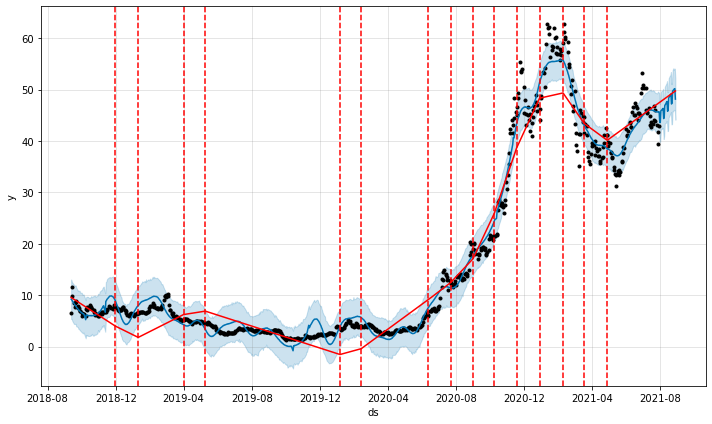

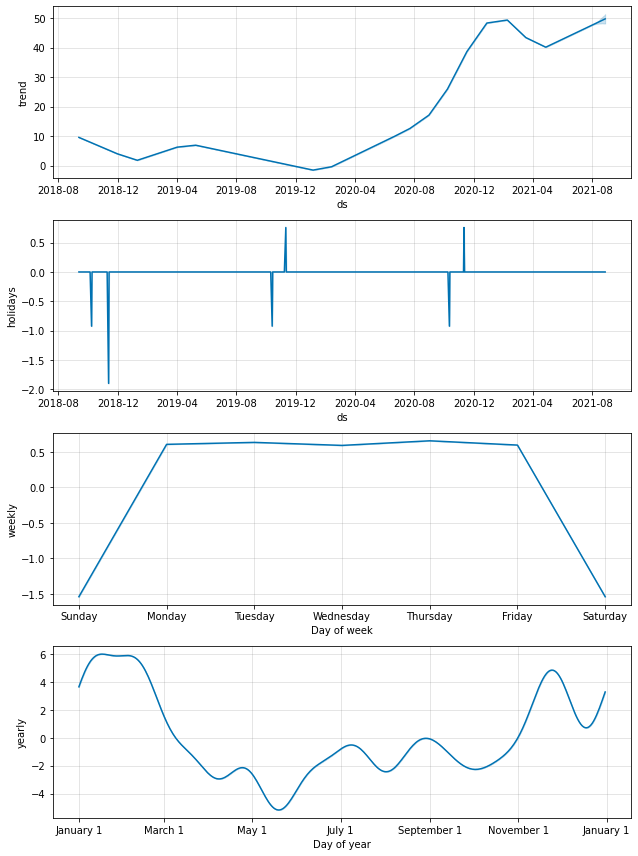

In [24]:
# IMPORTANT: To be consistent with future modeling is recommended to change Prophet's parameters in the cell at the top containing all parameters. 
# But for quick tests is possible to change it also directly here
df_pred, m, seasonalities = easyprophet.fit_predict(
    df=ts,                         # input df. Must contain 2 colums: "ds" and "y", and optionally all the exogenous variables(x_vars) 
    plot_predictions=True,         # Boolean, whether to plot the Predictions & Observed values or not
    plot_pred_interactive=True,    # Boolean, whether to plot Predictions & Observed values using an Interactive plots of plotly
    plot_components=True,          # Boolean, whether to plot forecasts components: Trend & seasonalities (weekly/yearly & holidays if added)
    freq_data=freq_data,                             # Frequency of the data, used for making future predictions (pd.date_range format: 'H':hourly, 'D':Daily, 'MS':Month Start, 'M':Month End)
    future_pred_period=future_pred_period,           # N° of periods (hours/days/weeks) to predict in the future. False for no future predictions (default=False)
    growth=growth,                                   # linear or logistic trend. If logistic you need to provide cap and floor of your predictions as well as historic data.  (default="linear")
    cap=cap,                                         # Name of the column containing the carrying capacity, i.e. the saturating maximum (must be specified for every row in the df).
    floor=floor,                                     # Name of the column containing the floor (saturating minimum). To use a logistic growth trend with a saturating minimum, a maximum capacity must also be specified.
    yearly_seasonality=yearly_seasonality,           # Whether to include yearly seasonality. Can be 'auto', True, False (default="auto")
    weekly_seasonality=weekly_seasonality,           # Whether to include weekly seasonality. Can be 'auto', True, False (default="auto")
    daily_seasonality=daily_seasonality,             # Whether to include daily seasonality.  Can be 'auto', True, False (default="auto")
    custom_seasonality=custom_seasonality,           # List, containing custom seasonality's [name, freq_period in a year, fourier_order] (e.g ["Quarterly", (365.25/4), 10]
    seasonality_mode=seasonality_mode,               # 'additive' or 'multiplicative' (default="additive")
    seasonality_prior_scale=seasonality_prior_scale, # strength of the seasonality model. larger values => larger seasonal fluctuations (default=10.0)
    holidays_prior_scale=holidays_prior_scale,       # strength of the holiday components model (default=10.0)
    holidays_country=holidays_country,               # name of the country of which load standard holidays (e.g. "US") (default=False)
    interval_width=interval_width,                   # Float, width of the uncertainty intervals provided for the forecast (default=0.80)
    changepoints=changepoints,                       # List of dates at which to include potential changepoints (default=None)
    n_changepoints=n_changepoints,                   # Number of potential changepoints to include. Not used if input `changepoints` is supplied (default=25)
    changepoint_range=changepoint_range,             # Proportion of history in which trend changepoints will be estimated (default=0.80)
    changepoint_prior_scale=changepoint_prior_scale, # Flexibility of automatic changepoint selection & consequently of the trend. Increase it to make the trend more flexible (default=0.05) 
   )

### A.2 Export the full table of future predictions, along with past values (with indication if they were anomalies)
The table below contains the output of the model. It contains the following columns:
* **ds**: date/time of the observation
* **trend**: underlying trend in case of no seasonal/holidays effect. It’s the g(t) in the formula above
* **yhat_lower / upper**: lower/upper limit of the interval of confidence of the predictions
* **yearly / weekly / daily**: seasonal effects on the prediction for each ds. It’s the s(t) in the formula above
* **holidays**: seasonal effect of the holidays on the prediction for each ds.
It’s the h(t) in the formula above
* **yhat**: Predicted value considering all the effects. 
It’s the y(t) in the formula above
* **fact**: Real observed value, useful to compare it with yhat and check the performance of the predictions
* **anomaly**: Categoric variables used to signal if observed values are higher/lower than the interval of confidence created
  * anomaly = 1 if fact > yhat_upper
  * anomaly = -1 if fact < yhat_lower
  * anomaly = 0 if yhat_lower < fact < yhat_upper
* **importance**: importance of the anomaly in % terms. 
  * if anomaly = 1: importance = fact - yhat upper
  * if anomaly = -1: importance = yhat lower - fact

A **sample** of the table is reported below, while the whole table (including all observations) is being **exported** in a file with the name specified by the  *f_out_name* parameter below

In [38]:
#### IMPORTANT: Be sure to have the output path in your Gdrive. In this example you need to have the following structure: "gdrive/My Drive/Colab Notebooks/Output/" 
f_out_name = f"{y_var}_A_PROPHET_predictions.csv"    # Choose the desired output file name

predictions = easyprophet.detect_anomalies(df_pred)
print(f"N° of anomalies in past data: {len(predictions[predictions['anomaly']!=0])} on {len(predictions)} rows"
      f" ({len(predictions[predictions['anomaly']!=0]) / len(predictions):0.1%} of total)")

print("\nDescriptive statistics of upper-anomalies ('fact' value higher than 'yhat_upper'):")
predictions[predictions["anomaly"] == 1]["importance"].describe()
print("\n\nDescriptive statistics of lower-anomalies ('fact' value lower than 'yhat_lower'):")
predictions[predictions["anomaly"] == -1]["importance"].describe()

predictions.to_csv(f"./Output/{f_out_name}")
print(f"\n\nExported df containing anomalies & future predictions")
predictions[predictions['anomaly']!=0].head()

N° of anomalies in past data: 60 on 755 rows (7.9% of total)

Descriptive statistics of upper-anomalies ('fact' value higher than 'yhat_upper'):


count    36.000000
mean      0.036989
std       0.028230
min       0.001126
25%       0.016033
50%       0.032003
75%       0.051353
max       0.111293
Name: importance, dtype: float64



Descriptive statistics of lower-anomalies ('fact' value lower than 'yhat_lower'):


count    24.000000
mean      0.046391
std       0.045267
min       0.000061
25%       0.006795
50%       0.040241
75%       0.066934
max       0.183767
Name: importance, dtype: float64



Exported df containing anomalies & future predictions


ds      trend  yhat_lower  yhat_upper  holidays    weekly  \
118 2019-03-05   4.750270    2.232335    9.929069       0.0  0.632652   
525 2020-10-13  27.516881   22.631778   29.871207       0.0  0.632652   
534 2020-10-26  31.654223   27.832901   35.182945       0.0  0.605203   
536 2020-10-28  32.290738   28.451727   36.007359       0.0  0.590268   
542 2020-11-05  34.836795   32.678287   40.084950       0.0  0.655033   

       yearly       yhat       fact  anomaly  importance  
118  0.734270   6.117192  10.160000        1    0.022729  
525 -1.902341  26.247192  21.620001       -1    0.046798  
534 -0.819573  31.439853  26.010000       -1    0.070085  
536 -0.554421  32.326584  27.510000       -1    0.034232  
542  0.987825  36.479653  42.349998        1    0.053484

### A.3 Diagnostics: cross validation for a range of historical cutoffs to measure forecast error
Perform cross-validation selecting cutoff points in the past and by fitting the model for each of them using data only up to that cutoff point.

This technique has many advantages on the simple split of train & test set, in fact it uses many train & test sets (at different periods), and  compute the average performance on them, providing more reliable forecast errors and increasing the generalizability of the model.

#### A.3.1 Use the cross_validation functions. Specify the following parameters:
* **initial**: the size of the initial training period
* **period**: the spacing between cutoff dates
* **horizon**: the forecast horizon
* **Output**: A df containing observed (y) and predicted (yhat) values, at each simulated forecast date and each cutoff date. A forecast is made for every observed point between cutoff and cutoff + horizon. 

Periods must be specified using pd.Timedelta compatible style (e.g. '5 days', '3 hours', '10 seconds').
By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon. For reference: https://facebook.github.io/prophet/docs/diagnostics.html

In [39]:
df_cv = cross_validation(m,
                         initial = cv_initial,
                         period  = cv_period,
                         horizon = cv_horizon
                         )
df_cv.head()

INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-03-06 00:00:00 and 2021-05-30 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2020-03-09  3.400579    2.680139    4.246316  3.29 2020-03-06
1 2020-03-10  3.237857    2.418994    4.023330  3.50 2020-03-06
2 2020-03-11  3.024249    2.262596    3.810984  3.32 2020-03-06
3 2020-03-12  2.874311    2.079479    3.667668  3.13 2020-03-06
4 2020-03-13  2.641361    1.835179    3.480117  3.11 2020-03-06

#### A.3.2. Compute accuracy of the prediction, as a function of the distance from the cutoff (how far into the future the prediction was), and export the file of performance

* **MSE**: Mean Squared Error
* **RMSE**: Root Mean Squared Error
* **MAE** Mean Absolute Error
* **MAPE**: Mean Absolute Percent Error
* **Coverage** of the yhat_lower and yhat_upper estimates

These are computed on a rolling window of the predictions in df_cv after sorting by horizon (ds minus cutoff). By default 10% of the predictions will be included in each window, but this can be changed with the rolling_window argument.

The 1° table below shows a sample of the accuracy of predictions varying the horizon period.

The 2° table below shows more generally the basic descriptive statistics of the performances. It's particularly important to pay attention to the mean of MAPE because it assess the Mean Average Percentage Error that we can expect applying this model to future data.

In [41]:
#### IMPORTANT: Be sure to have the output path in your Gdrive. In this example you need to have the following structure:
#### "gdrive/My Drive/Colab Notebooks/Output/" 
f_out_name = f"{y_var}_A_PROPHET_performance.csv"    # Choose the desired output file name

df_p = performance_metrics(df_cv)
df_p.to_csv(f"./Output/{f_out_name}", index=False)
print(f"Exported df containing performance of Prophet model")
print("Descriptive statistics for each performance metric:")
df_p.drop(axis=1,columns={"horizon"}).describe()

Exported df containing performance of Prophet model
Descriptive statistics for each performance metric:


mse       rmse        mae       mape      mdape   coverage
count   54.000000  54.000000  54.000000  54.000000  54.000000  54.000000
mean   157.464870  12.403116   9.709781   0.387753   0.365665   0.100167
std     47.290426   1.922507   1.634846   0.066718   0.052285   0.083272
min     78.705640   8.871620   6.649022   0.241596   0.218133   0.000000
25%    120.027380  10.955508   8.389489   0.348128   0.342204   0.000000
50%    161.289445  12.699972  10.178657   0.407878   0.374973   0.095833
75%    194.417641  13.943373  11.044095   0.435226   0.396886   0.166667
max    271.358271  16.472956  12.722287   0.475408   0.448754   0.291667

#### A.3.3 Visualize Cross validation performance metrics
* **Dots** show the error for each prediction in df_cv. 
* **The blue line** shows the metric selected (mse, rmse, mae, mape), where the mean is taken over a rolling window of the dots
* The **rolling_window** parameter specifies the proportion of forecasts to use in each rolling window (default=0.1, corresponding to 10% of rows from df_cv included in each window). Increasing this will lead to a smoother average curve in the figure.

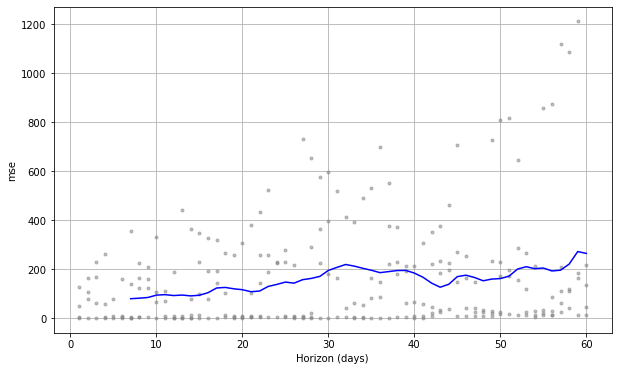

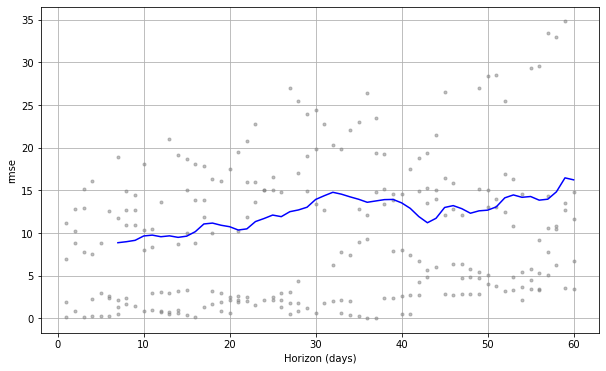

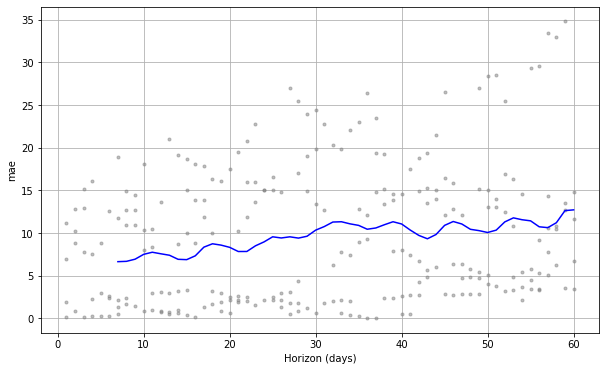

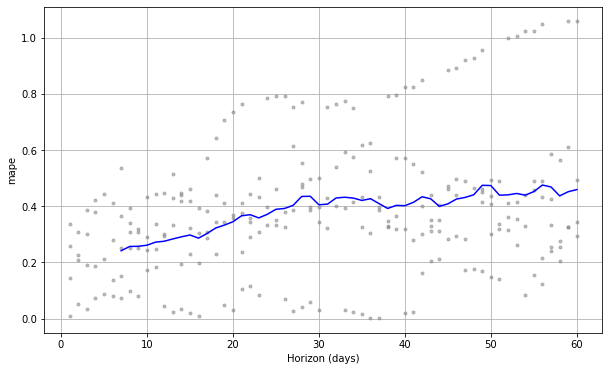

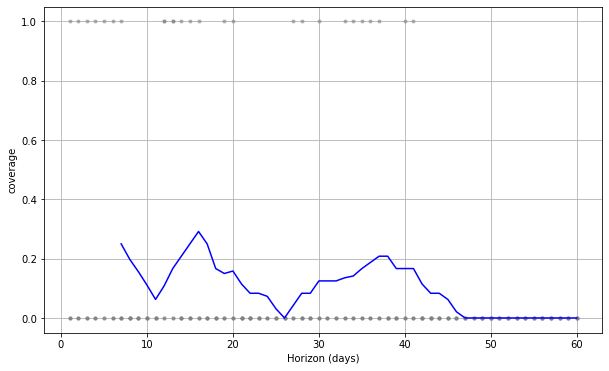

In [42]:
list_metrics = ["mse", "rmse", "mae", "mape", "coverage"]
for metrics_i in list_metrics:
    fig = plot_cross_validation_metric(df_cv,
                                       metric=metrics_i,
                                       rolling_window=cv_rolling_window)

### A.4 Models comparison & parameters fine-tuning
In this section is possible to compare 2 or more different models having different parameters. The parameters can be changed manually in the estimation phases of m1 & m2 models.
Once the models are fitted, it’s possible to compare the results obtained in order to identify which parameters return the best performance.
This is done first of all graphically (A.4.1), and then performing a grid-search (A.4.2).

#### A.4.1. Fit & compare 2 or more models having some different parameters
Try to manually change some parameters and check the output results

1.A Plot of Observed & Predicted values + Changepoints (date points where the time series have abrupt changes in the trajectory)


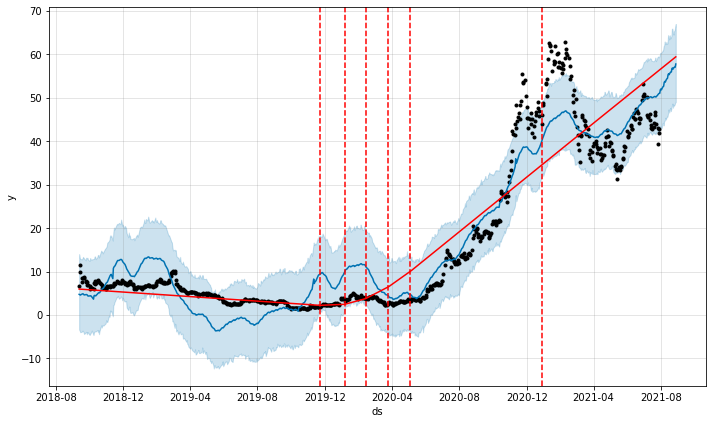

In [43]:
df_pred1, m1, seasonalities = easyprophet.fit_predict(
    df=ts,                         # input df. Must contain 2 colums: "ds" and "y", and optionally all the exogenous variables(x_vars) 
    plot_predictions=True,         # Boolean, whether to plot the Predictions & Observed values or not
    plot_pred_interactive=False,   # Boolean, whether to plot Predictions & Observed values using an Interactive plots of plotly
    plot_components=False,         # Boolean, whether to plot forecasts components: Trend & seasonalities (weekly/yearly & holidays if added)
    freq_data=freq_data,                             # Frequency of the data, used for making future predictions (pd.date_range format: 'H':hourly, 'D':Daily, 'MS':Month Start, 'M':Month End)
    future_pred_period=future_pred_period,           # N° of periods (hours/days/weeks) to predict in the future. False for no future predictions (default=False)
    growth=growth,                                   # linear or logistic trend. If logistic you need to provide cap and floor of your predictions as well as historic data.  (default="linear")
    cap=cap,                                         # Name of the column containing the carrying capacity, i.e. the saturating maximum (must be specified for every row in the df).
    floor=floor,                                     # Name of the column containing the floor (saturating minimum). To use a logistic growth trend with a saturating minimum, a maximum capacity must also be specified.
    yearly_seasonality=yearly_seasonality,           # Whether to include yearly seasonality. Can be 'auto', True, False (default="auto")
    weekly_seasonality=weekly_seasonality,           # Whether to include weekly seasonality. Can be 'auto', True, False (default="auto")
    daily_seasonality=daily_seasonality,             # Whether to include daily seasonality.  Can be 'auto', True, False (default="auto")
    custom_seasonality=custom_seasonality,           # List, containing custom seasonality's [name, freq_period in a year, fourier_order] (e.g ["Quarterly", (365.25/4), 10]
    seasonality_mode=seasonality_mode,               # 'additive' or 'multiplicative' (default="additive")
    seasonality_prior_scale=seasonality_prior_scale, # strength of the seasonality model. larger values => larger seasonal fluctuations (default=10.0)
    holidays_prior_scale=holidays_prior_scale,       # strength of the holiday components model (default=10.0)
    holidays_country=holidays_country,               # name of the country of which load standard holidays (e.g. "US") (default=False)
    interval_width=interval_width,                   # Float, width of the uncertainty intervals provided for the forecast (default=0.80)
    changepoints=changepoints,                       # List of dates at which to include potential changepoints (default=None)
    n_changepoints=n_changepoints,                   # Number of potential changepoints to include. Not used if input `changepoints` is supplied (default=25)
    changepoint_range=changepoint_range,             # Proportion of history in which trend changepoints will be estimated (default=0.80)
    changepoint_prior_scale=0.01,                    # Flexibility of automatic changepoint selection & consequently of the trend. Increase it to make the trend more flexible (default=0.05) 
    )
                                             

1.A Plot of Observed & Predicted values + Changepoints (date points where the time series have abrupt changes in the trajectory)


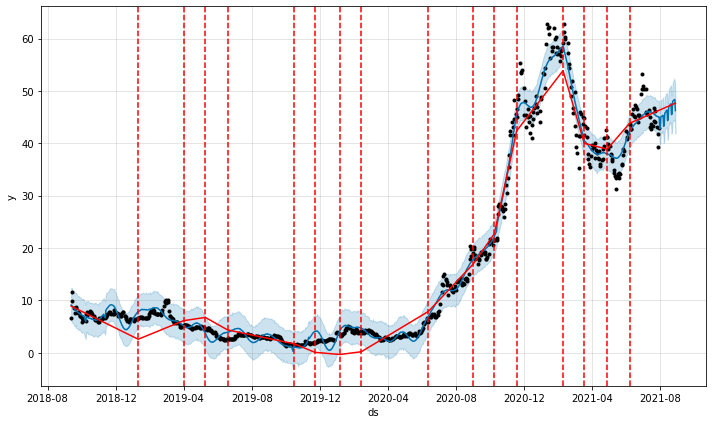

In [30]:
df_pred2, m2, seasonalities = easyprophet.fit_predict(
    df=ts,                         # input df. Must contain 2 colums: "ds" and "y", and optionally all the exogenous variables(x_vars) 
    plot_predictions=True,         # Boolean, whether to plot the Predictions & Observed values or not
    plot_pred_interactive=False,   # Boolean, whether to plot Predictions & Observed values using an Interactive plots of plotly
    plot_components=False,         # Boolean, whether to plot forecasts components: Trend & seasonalities (weekly/yearly & holidays if added)
    freq_data=freq_data,                             # Frequency of the data, used for making future predictions (pd.date_range format: 'H':hourly, 'D':Daily, 'MS':Month Start, 'M':Month End)
    future_pred_period=future_pred_period,           # N° of periods (hours/days/weeks) to predict in the future. False for no future predictions (default=False)
    growth=growth,                                   # linear or logistic trend. If logistic you need to provide cap and floor of your predictions as well as historic data.  (default="linear")
    cap=cap,                                         # Name of the column containing the carrying capacity, i.e. the saturating maximum (must be specified for every row in the df).
    floor=floor,                                     # Name of the column containing the floor (saturating minimum). To use a logistic growth trend with a saturating minimum, a maximum capacity must also be specified.
    yearly_seasonality=yearly_seasonality,           # Whether to include yearly seasonality. Can be 'auto', True, False (default="auto")
    weekly_seasonality=weekly_seasonality,           # Whether to include weekly seasonality. Can be 'auto', True, False (default="auto")
    daily_seasonality=daily_seasonality,             # Whether to include daily seasonality.  Can be 'auto', True, False (default="auto")
    custom_seasonality=custom_seasonality,           # List, containing custom seasonality's [name, freq_period in a year, fourier_order] (e.g ["Quarterly", (365.25/4), 10]
    seasonality_mode=seasonality_mode,               # 'additive' or 'multiplicative' (default="additive")
    seasonality_prior_scale=seasonality_prior_scale, # strength of the seasonality model. larger values => larger seasonal fluctuations (default=10.0)
    holidays_prior_scale=holidays_prior_scale,       # strength of the holiday components model (default=10.0)
    holidays_country=holidays_country,               # name of the country of which load standard holidays (e.g. "US") (default=False)
    interval_width=interval_width,                   # Float, width of the uncertainty intervals provided for the forecast (default=0.80)
    changepoints=changepoints,                       # List of dates at which to include potential changepoints (default=None)
    n_changepoints=n_changepoints,                   # Number of potential changepoints to include. Not used if input `changepoints` is supplied (default=25)
    changepoint_range=changepoint_range,             # Proportion of history in which trend changepoints will be estimated (default=0.80)
    changepoint_prior_scale=0.25,                    # Flexibility of automatic changepoint selection & consequently of the trend. Increase it to make the trend more flexible (default=0.05) 
   )

1.A Plot of Observed & Predicted values + Changepoints (date points where the time series have abrupt changes in the trajectory)


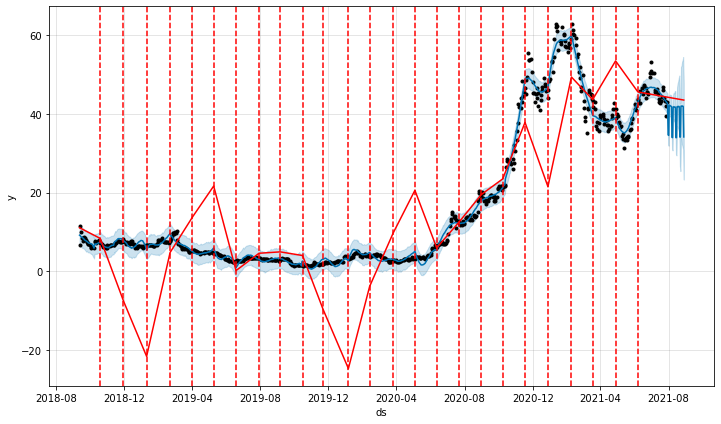

In [44]:
df_pred3, m3, seasonalities = easyprophet.fit_predict(
    df=ts,                         # input df. Must contain 2 colums: "ds" and "y", and optionally all the exogenous variables(x_vars) 
    plot_predictions=True,         # Boolean, whether to plot the Predictions & Observed values or not
    plot_pred_interactive=False,   # Boolean, whether to plot Predictions & Observed values using an Interactive plots of plotly
    plot_components=False,         # Boolean, whether to plot forecasts components: Trend & seasonalities (weekly/yearly & holidays if added)
    freq_data=freq_data,                             # Frequency of the data, used for making future predictions (pd.date_range format: 'H':hourly, 'D':Daily, 'MS':Month Start, 'M':Month End)
    future_pred_period=future_pred_period,           # N° of periods (hours/days/weeks) to predict in the future. False for no future predictions (default=False)
    growth=growth,                                   # linear or logistic trend. If logistic you need to provide cap and floor of your predictions as well as historic data.  (default="linear")
    cap=cap,                                         # Name of the column containing the carrying capacity, i.e. the saturating maximum (must be specified for every row in the df).
    floor=floor,                                     # Name of the column containing the floor (saturating minimum). To use a logistic growth trend with a saturating minimum, a maximum capacity must also be specified.
    yearly_seasonality=yearly_seasonality,           # Whether to include yearly seasonality. Can be 'auto', True, False (default="auto")
    weekly_seasonality=weekly_seasonality,           # Whether to include weekly seasonality. Can be 'auto', True, False (default="auto")
    daily_seasonality=daily_seasonality,             # Whether to include daily seasonality.  Can be 'auto', True, False (default="auto")
    custom_seasonality=custom_seasonality,           # List, containing custom seasonality's [name, freq_period in a year, fourier_order] (e.g ["Quarterly", (365.25/4), 10]
    seasonality_mode=seasonality_mode,               # 'additive' or 'multiplicative' (default="additive")
    seasonality_prior_scale=seasonality_prior_scale, # strength of the seasonality model. larger values => larger seasonal fluctuations (default=10.0)
    holidays_prior_scale=holidays_prior_scale,       # strength of the holiday components model (default=10.0)
    holidays_country=holidays_country,               # name of the country of which load standard holidays (e.g. "US") (default=False)
    interval_width=interval_width,                   # Float, width of the uncertainty intervals provided for the forecast (default=0.80)
    changepoints=changepoints,                       # List of dates at which to include potential changepoints (default=None)
    n_changepoints=n_changepoints,                   # Number of potential changepoints to include. Not used if input `changepoints` is supplied (default=25)
    changepoint_range=changepoint_range,             # Proportion of history in which trend changepoints will be estimated (default=0.80)
    changepoint_prior_scale=5,                    # Flexibility of automatic changepoint selection & consequently of the trend. Increase it to make the trend more flexible (default=0.05) 
   )

#### A.4.2. Create a grid of parameters to iteratively fit models & compare their diagnostic metrics
The grid-search creates Diagnostics results (same of section A.3) iteratively for each combination of models and parameters.
In this case are provided 3 different models (3 different settings).
Note: Pay attention in providing too much parameters because the N° of cross-validation to be run could increase exponentially (e.g. 3 models * 3 initial * 3 periods * 3 horizon = 81 different settings)

The table below shows the performance of the 3 models fitted, sorted in the way they were passed (1° row contains results of model m, 2° row of m1, 3° row of m2)

* **Cross validation**: Run cross validation for each model fitted, and return all diagnostic metrics
* **Output**: a dataframe containing all the diagnostic metrics for each model fitted, (sorted in the order of the param_grid passed)

In [45]:
param_grid = {'model'   : [m, m1, m2, m3],
              'initial' : [cv_initial],
              'period'  : [cv_period],
              'horizon' : [cv_horizon]}
param_grid = list(easyprophet.create_grid(param_grid))

cv_table = easyprophet.cross_validation_compare_models(cross_valid_params=param_grid, metric='mape')
cv_table

INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-03-06 00:00:00 and 2021-05-30 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-03-06 00:00:00 and 2021-05-30 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-03-06 00:00:00 and 2021-05-30 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-03-06 00:00:00 and 2021-05-30 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

horizon         mse       rmse       mae      mape  coverage   initial  \
0 60 days  155.580999  12.473211  9.628970  0.381942  0.100806  500 days   
0 60 days  162.170242  12.734608  9.106411  0.395622  0.209677  500 days   
0 60 days  125.208592  11.189664  8.126047  0.409302  0.120968  500 days   
0 60 days   79.172080   8.897869  6.117427  0.214791  0.584677  500 days   

    period  
0  90 days  
0  90 days  
0  90 days  
0  90 days

# B. UNIVARIATE ARIMA MODELING: 
The ARIMA forecasting equation for a stationary time series is a linear (i.e., regression-type) equation in which the predictors consist of lags of the dependent variable and/or lags of the forecast errors.
This means that predicted value of Y  are: a constant and/or a weighted sum of one or more recent values of Y and/or a weighted sum of one or more recent values of the errors.

The general equation is:
`ŷt = a0 + b1(yt-1,...,yt-n)`

This can be further detailed into:
 `ŷt   =   μ + ϕ1 yt-1 + … + ϕp yt-p - θ1et-1 - … - θqet-q`

where 
* **ϕs**: **Autoregressive** part (AR) of the ARIMA. Indicates that the evolving variable of interest is regressed on its own lagged values.
* **θs**: **Moving Average** (MA) part of the ARIMA. Indicates that the regression error is actually a linear combination of error terms whose values occurred contemporaneously and at various times in the past. 
* The **I** part of the ARIMA stands for **"integrated"**, and indicates that the data values have been replaced with the difference between their values and the previous values

To identify the appropriate ARIMA model for Y, you begin by determining the order of differencing (d) needing to stationarize the series and remove the gross features of seasonality, perhaps in conjunction with a variance-stabilizing transformation such as logging or deflating. 
Once differenced, the stationarized series may still have autocorrelated errors, suggesting that some number of AR terms (p ≥ 1) and/or some number MA terms (q ≥ 1) are also needed in the forecasting equation.

### B.1. Time Series Decompositions: Decompose Observed TS into Trend, Seasonality and Random component
* Visualize the **Trend**, **Seasonal** and **Residual** components
* Identify the presence of **Seasonality**

In [33]:
############--- For ARIMA modeling the ts need to have a datetimeindex and the y values ---############
ts2 = ts.copy()
ts2.set_index('ds', inplace=True)
ts2.index = pd.DatetimeIndex(ts2.index.values, freq=ts2.index.inferred_freq)

# Cut initial points of time series in order to make it possible to run auto-arima
ts2 = ts2.tail(500)
ts2.shape
ts2.head()
ts2.tail()

(500, 1)

y
2019-08-06  3.08
2019-08-07  3.09
2019-08-08  3.17
2019-08-09  3.13
2019-08-12  3.05

y
2021-07-23  43.990002
2021-07-26  43.169998
2021-07-27  39.360001
2021-07-28  41.840000
2021-07-29  42.869900

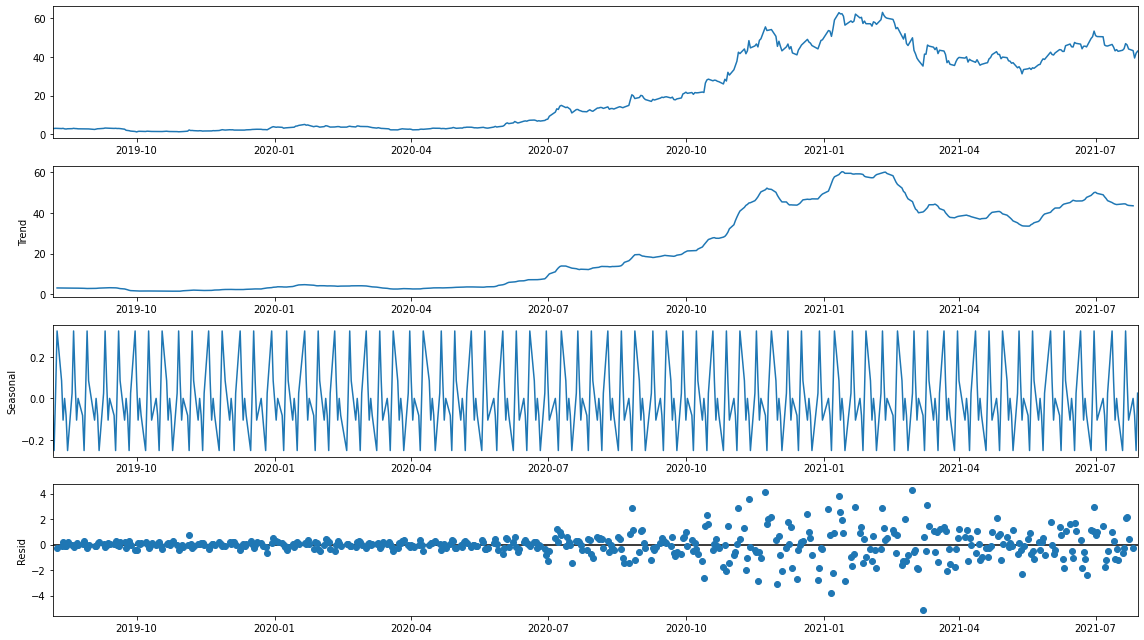

In [34]:
plt.rcParams['figure.figsize'] = [16, 9]
result = seasonal_decompose(ts2,
                            model='additive',
                            period=freq_period)
result.plot()
plt.show();

### B.2 Examine ACF/PACF of the original Time Series

* The **ACF** (Autocorellation Function) is a measure of the correlation between observations of a time series that are separated by k time units (yt and yt–k).
* The **PACF** (Partial Autocorrelation Function) gives the partial correlation of a stationary time series with its own lagged values, regressed the values of the time series at all shorter lags. It is basically the autocorrelation between 
yt and yt+k that is not accounted for by lags 1 through k-1, inclusive

In the following graphs is possible to:
* Check **Stationarity**: Augmented Dickey-Fuller Test to test stationarity of the TS. If p-value < 0.05 we reject the Null hypothesis of Non-stationarity
* Examine **ACF**: If the ACF displays a sharp cutoff, the lag beyond which the ACF cuts off is the indicated number of **MA** terms.
* Examine **PACF**: If the PACF displays a sharp cutoff, the lag at which the PACF cuts off is the indicated number of **AR** terms.

For more reference: https://people.duke.edu/~rnau/arimrule.htm

p-value ADF Test, Original ts2: 0.8274363085151919


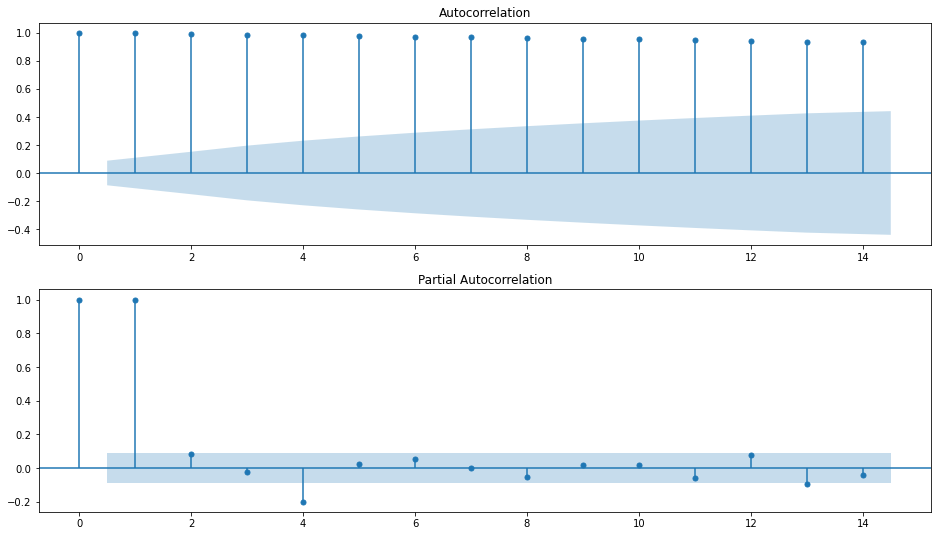

In [35]:
# ACF/PACF of the original Time Series
fig, ax = plt.subplots(2, figsize=(16,9))
ax[0] = plot_acf(ts2.dropna(), ax=ax[0], lags=(freq_period*2))
ax[1] = plot_pacf(ts2.dropna(), ax=ax[1], lags=(freq_period*2))
print("p-value ADF Test, Original ts2:", adfuller(ts2.dropna())[1])

### B.3 Differentiate the Time Series
* Check **Stationarity**: Augmented Dickey-Fuller Test to test stationarity of the TS. If p-value < 0.05 we reject the Null hypothesis of Non-stationarity
* Examine **ACF/PACF of the differentiated TS**: Seasonal ACF spikes => Seasonal MA terms; Seasonal PACF spikes => Seasonal AR terms
* Identify **Seasonality**; check whether the daily/weekly/yearly difference removes the seasonality.

p-value ADF Test, differentiated ts2: 0.00013085900569446954


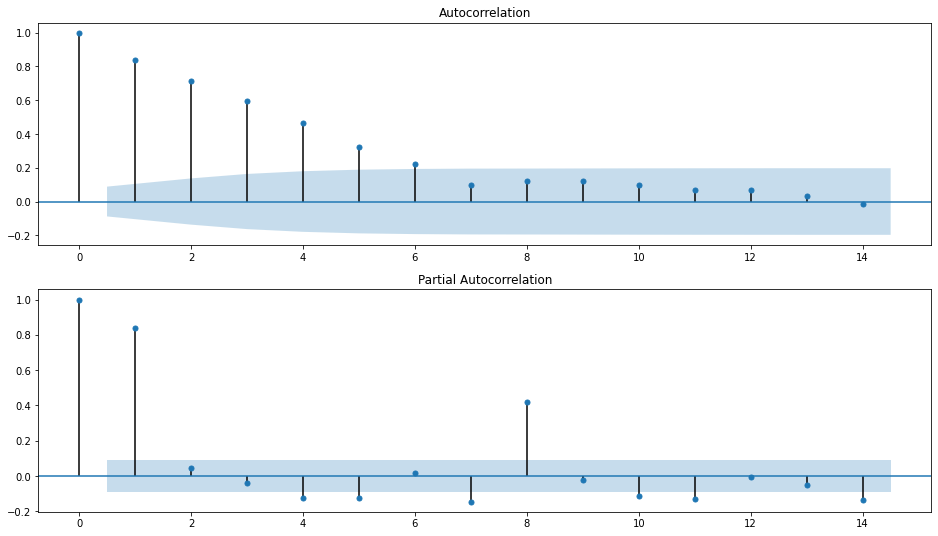

In [ ]:
# ACF/PACF of the Differentiated Time Series
diff_order = 7      # Specify the order of differencing desired

ts2_diff = ts2.diff(diff_order)
fig, ax = plt.subplots(2, figsize=(16,9))
ax[0] = plot_acf(ts2_diff.dropna(), ax=ax[0], lags=(freq_period*2))
ax[1] = plot_pacf(ts2_diff.dropna(), ax=ax[1], lags=(freq_period*2))
print("p-value ADF Test, differentiated ts2:", adfuller(ts2_diff.dropna())[1])

### B.4 Time Series univariate modeling:  Create ARIMA models for yt = a0 + b1(yt-1,...,yt-n)
* Model 1 - **ARIMA**: Arima Model manually specifying AR / MA / 1° Difference terms & Seasonal AR / MA Difference terms
* Model 2 - **AUTO-ARIMA**: Arima Model automatically identify all terms that optimize the model performance

####  B.4.1 Model 1 - ARIMA: Arima Model manually specifying AR / MA / 1° Difference terms & Seasonal AR / MA Difference terms

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)




                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  499
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -2137.126
Method:                       css-mle   S.D. of innovations             17.529
Date:                Sun, 25 Jul 2021   AIC                           4280.253
Time:                        10:08:59   BIC                           4292.891
Sample:                             1   HQIC                          4285.212
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2035      0.723      1.666      0.096      -0.213       2.620
ma.L1.D.y     -0.0794      0.045     -1.779      0.075      -0.167       0.008
                                    Roots           

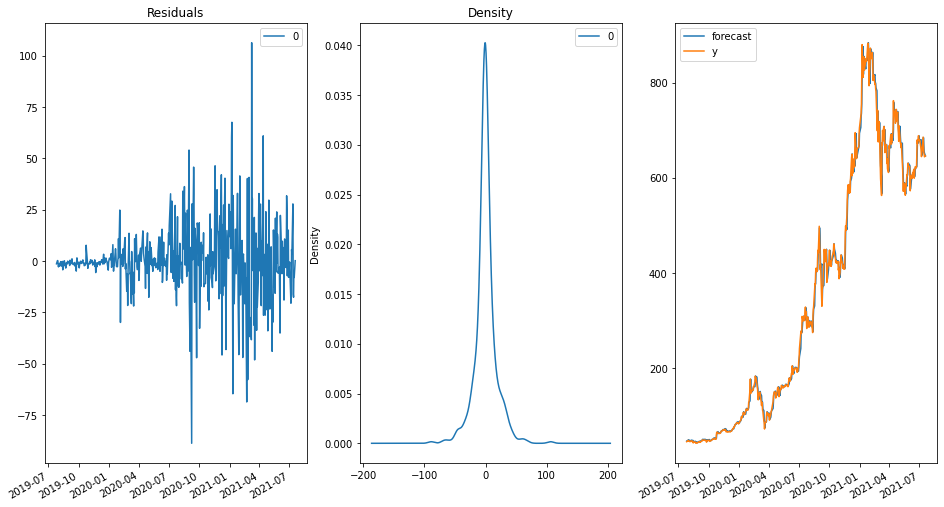

In [ ]:
# IMPORTANT: YOU NEED TO MANUALLY CHOOSE THE CORRECT ORDER FOR EACH ARIMA TERMS
model_arima = ARIMA(ts2.astype('float32'), order=(0,1,1)).fit(disp=0)
print(model_arima.summary())

print("\nPlot residuals (Graphs 1-2) to ensure there are no patterns, and observed vs fitted values (Graph 3) to check the quality of predictons")
residuals = pd.DataFrame(model_arima.resid)
fig, ax = plt.subplots(1,3)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
model_arima.plot_predict(dynamic=False, ax=ax[2])
plt.show();

####  B.4.2 Model 2 - AUTO-ARIMA: Arima Model automatically identify all terms that optimize the model performance

It's recommended to let Auto-ARIMA choose the best parameters, by just providing a limit to the ARIMA and Seasonal ARIMA parameters: 
* **max_d**: Max value of `d`, or the maximum number of non-seasonal differences. Must be a positive integer >= `d`
* **max_p**: Max value  of `p`, the order of the AR part of the model. Must be >= `start_p`
* **max_q**: Max value  of `q`, the order of the MA part of the model. Must be >= `start_q`
* **max_D**: Max value of `D`, i.e. the maximum number of non-seasonal differences. Must be a positive integer >= `D`
* **max_P**: Max value  of `P`, the order of the AR part of the seasonal model. Must be >= `start_P`
* **max_Q**: Max value  of `Q`, the order of the MA part of the seasonal model. Must be >= `start_Q`

The output table includes a summary of the model performance. Most important things to check is:
* **AIC**: The Akaike information criterion is an estimator of out-of-sample prediction error and thereby relative quality of statistical models for a given set of data. It is used to compare different models in order to select the model that minimizes the information loss (i.e. minimizes the AIC)
* **Ljung-Box (Q)**: Statistical test of whether any of a group of autocorrelations of a time series are different from zero. Instead of testing randomness at each distinct lag, it tests the "overall" randomness based on a number of lags. If the p value is greater than 0.05 then the residuals are independent which we want for the model to be correct.
* **AR & MA coefficients**: It's good to check the size of the coefficient and the corresponding significance (if it has a significant effect on the dependent variable). A coefficient is significant if its pvalue is < 0.05.


In [ ]:
# Note that due to stationarity issues, auto-ARIMA might not find a suitable model that will converge.
# If this is the case, a `ValueError` will be thrown suggesting stationarity-inducing measures be taken prior to re-fitting or that a new range of `order` values be selected. 
automodel = pm.auto_arima(ts2, 
                          ##########--- AR/MA terms on the original TS ---##########
                          d=0,         # Order of first-differencing. If None (default), will automatically be selected based on the results of the `test`
                          max_d=2,        # Max value of `d`, or the maximum number of non-seasonal differences. Must be a positive integer >= `d`
                          start_p=0,      # Starting value of `p`, the order of the AR model
                          max_p=2,        # Max value  of `p`. Must be >= `start_p`
                          start_q=0,      # Starting value of `q`, the order of the MA model
                          max_q=2,        # Max value  of `q`. Must be >= `start_q`
                          
                          ##########--- SEASONAL AR/MA terms on the seasonal differentiated TS ---##########
                          D=1,            # Order of the seasonal differencing. If None (default), will automatically be selected based on the results of the `seasonal_test`
                          max_D=2,        # Max value of `D`, or the maximum number of seasonal differences. Must be a positive integer >= `D`
                          start_P=0,      # Starting value of `P`, the order of the AR portion of the seasonal model
                          max_P=2,        # Max value of `P`. Must be >= `start_P`
                          start_Q=0,      # Starting value of `Q`, the order of the MA portion of the seasonal model
                          max_Q=2,        # Max value  of `Q`. Must be >= `start_Q`
                          
                          ##########--- GENERAL PARAMETERS ---##########
                          max_order=4,    # Max value of p+q+P+Q if model selection is not stepwise. If the `p`+`q` >= `max_order`, a model will *not* be fit with those parameters, but will progress to the next combination.
                                          # Default is 5. If `max_order` is None, it means there are no constraints on maximum order.
                          m = freq_period,# Period for seasonal differencing (e.g. 12 for monthly, 7 for weekly, 24 for hourly) 
                          seasonal=True,  # Whether to fit a seasonal ARIMA. Default is True. Note that if `seasonal` is True and `m` == 1, `seasonal` will be set to False.
                          stationary=False, # Whether the time-series is stationary and `d` should be set to zero.
                          test="adf",     # Type of unit root test to use in order to detect stationarity if `stationary` is False and `d` is None.
                          trace=False     # Whether to print status on the fits. 
                         )
automodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  500
Model:             SARIMAX(2, 0, 1)x(2, 1, [], 7)   Log Likelihood               -2165.500
Date:                            Sun, 25 Jul 2021   AIC                           4343.001
Time:                                    10:10:49   BIC                           4368.204
Sample:                                         0   HQIC                          4352.896
                                            - 500                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0166      0.030     -0.557      0.577      -0.075       0.042
ar.L2          0.9172      0.029     31.488      0.000       0.860       0.974
ma.L1          0.9298      0.040     23.276      0.000       0.851       1.008
ar.S.L7       -0.6265      0.028    -22.355      0.000      -0.681      -0.572
ar.S.L14      -0.4578      0.031    -14.790      0.000      -0.519      -0.397
sigma2       377.9700     16.055     23.542      0.000     346.503     409.437
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               246.35
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):              16.86   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### B.5 Check model performance using out-of-time cross validation
1. **Split** ts data intro **train set** (data used to train the model) & **test set** (data not used to train the model, but to check the validity of the trained model)
1. **Fit the model on train** data
1. **Fit test data** using the model trained on the train data
1. Display the plot containing **observed & fitted values**
1. Calculate **diagnostic metrics** comparing test & fitted data

In [ ]:
############--- B.5.1 Split ts into train & test (test will contain 'future_pred_period' rows) ---############
train_y = ts2.head(-future_pred_period)
test_y = ts2.tail(future_pred_period)
print(f"ORIGINAL TS: \tstarting at {ts2.index.min()} - Ending at {ts2.index.max()}")
print(f"TRAINING SET: \tstarting at {train_y.index.min()} - Ending at {train_y.index.max()}")
print(f"TEST SET: \tstarting at {test_y.index.min()} - Ending at {test_y.index.max()}")

ORIGINAL TS: 	starting at 2019-07-25 00:00:00 - Ending at 2021-07-19 00:00:00
TRAINING SET: 	starting at 2019-07-25 00:00:00 - Ending at 2021-06-04 00:00:00
TEST SET: 	starting at 2021-06-07 00:00:00 - Ending at 2021-07-19 00:00:00


In [ ]:
############--- B.5.2 Fit the model using just train data ---############
automodel_train = pm.auto_arima(train_y, 
                                ##########--- AR/MA terms on the original TS ---##########
                                d=0,         # Order of first-differencing. If None (default), will automatically be selected based on the results of the `test`
                                max_d=2,        # Max value of `d`, or the maximum number of non-seasonal differences. Must be a positive integer >= `d`
                                start_p=0,      # Starting value of `p`, the order of the AR model
                                max_p=2,        # Max value  of `p`. Must be >= `start_p`
                                start_q=0,      # Starting value of `q`, the order of the MA model
                                max_q=2,        # Max value  of `q`. Must be >= `start_q`
                                
                                ##########--- SEASONAL AR/MA terms on the seasonal differentiated TS ---##########
                                D=1,            # Order of the seasonal differencing. If None (default), will automatically be selected based on the results of the `seasonal_test`
                                max_D=2,        # Max value of `D`, or the maximum number of seasonal differences. Must be a positive integer >= `D`
                                start_P=0,      # Starting value of `P`, the order of the AR portion of the seasonal model
                                max_P=2,        # Max value of `P`. Must be >= `start_P`
                                start_Q=0,      # Starting value of `Q`, the order of the MA portion of the seasonal model
                                max_Q=2,        # Max value  of `Q`. Must be >= `start_Q`
                                
                                ##########--- GENERAL PARAMETERS ---##########
                                max_order=4,    # Max value of p+q+P+Q if model selection is not stepwise. If the `p`+`q` >= `max_order`, a model will *not* be fit with those parameters, but will progress to the next combination.
                                                # Default is 5. If `max_order` is None, it means there are no constraints on maximum order.
                                m = freq_period,# Period for seasonal differencing (e.g. 12 for monthly, 7 for weekly, 24 for hourly) 
                                seasonal=True,  # Whether to fit a seasonal ARIMA. Default is True. Note that if `seasonal` is True and `m` == 1, `seasonal` will be set to False.
                                stationary=False, # Whether the time-series is stationary and `d` should be set to zero.
                                test="adf",     # Type of unit root test to use in order to detect stationarity if `stationary` is False and `d` is None.
                                trace=False     # Whether to print status on the fits. 
                               )
automodel_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  470
Model:             SARIMAX(2, 0, 1)x(2, 1, [], 7)   Log Likelihood               -2037.700
Date:                            Sun, 25 Jul 2021   AIC                           4087.401
Time:                                    10:12:42   BIC                           4112.227
Sample:                                         0   HQIC                          4097.174
                                            - 470                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0133      0.030     -0.441      0.659      -0.072       0.046
ar.L2          0.9171      0.030     31.021      0.000       0.859       0.975
ma.L1          0.9238      0.041     22.440      0.000       0.843       1.005
ar.S.L7       -0.6195      0.029    -21.680      0.000      -0.675      -0.563
ar.S.L14      -0.4693      0.032    -14.847      0.000      -0.531      -0.407
sigma2       384.0372     16.636     23.084      0.000     351.430     416.644
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               246.35
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):              21.42   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

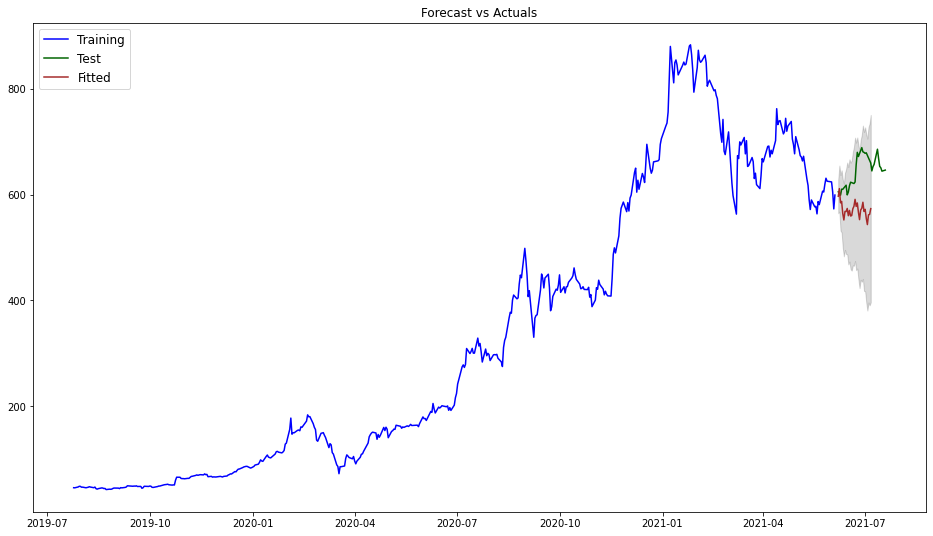

In [ ]:
############--- B.5.3 Fit the observations that have been removed (test data) using the model trained on the train data ---############
fitted, confint = automodel_train.predict(n_periods=future_pred_period,
                                          return_conf_int=True,
                                          alpha=0.10)         # Change the value of alpha in order to have a smaller/larger interval of confidence
index_of_fitted = pd.date_range(test_y.index[0], periods = future_pred_period, freq=ts2.index.inferred_freq)
fitted = pd.Series(fitted, index=index_of_fitted)
IC_lower = pd.Series(confint[:, 0], index=index_of_fitted)
IC_upper = pd.Series(confint[:, 1], index=index_of_fitted)

############--- B.5.4 Display the plot containing observed & fitted values ---############
plt.rcParams['figure.figsize'] = [16, 9]
plt.plot(train_y, color="blue", label='Training')
plt.plot(test_y, color='darkgreen', label='Test')
plt.plot(fitted, color='brown', label='Fitted')
plt.fill_between(IC_lower.index, IC_lower, IC_upper, color='k', alpha=.15)

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12)
plt.show();

In [ ]:
############--- B.5.5 Calculate diagnostic metrics comparing test & fitted data ---############
fitted = pd.DataFrame(fitted, index = fitted.index, columns=['y'])
print("Diagnostic metrics of Fitted vs Test observations:")

mape = np.mean(np.abs(fitted - test_y) / np.abs(test_y))  # MAPE
me = np.mean(fitted - test_y)  # ME
mae = mean_absolute_error(test_y, fitted)  # MAE
mpe = np.mean((fitted - test_y) / test_y)  # MPE
mse = mean_squared_error(test_y, fitted)  # MSE
rmse = sqrt(mse)  # RMSE
print(
    "ME   - Mean Error                 ", round(me.iloc[0], 3),
    "\nMAE  - Mean Absolute Error        ", round(mae, 3),
    "\nMAPE - Mean Absolute Percent Error", round(mape.iloc[0], 5),
    "\nMPE  - Mean Percentage Error      ", round(mpe.iloc[0], 5),
    "\nMSE  - Mean Squared Error         ", round(mse, 3),
    "\nRMSE - Root Mean Squared Error    ", round(rmse, 3),
)

Diagnostic metrics of Fitted vs Test observations:
ME   - Mean Error                  -62.3 
MAE  - Mean Absolute Error         72.754 
MAPE - Mean Absolute Percent Error 0.09615 
MPE  - Mean Percentage Error       -0.09494 
MSE  - Mean Squared Error          6419.906 
RMSE - Root Mean Squared Error     80.124


### B.6 Predict the future with the ARIMA models estimated
When predicting the future it’s not possible to assess the performance of the model, because “Observed” values are not available. So when predicting the future we assume that the performance are similar to the one obtained in previous section.
1. Make forecasts for "future_pred_period" ahead using the model fitted on all observed data
2. Display the plot containing predicted values (& past observed values)

ORIGINAL TS: 	starting at 2019-07-25 00:00:00 - Ending at 2021-07-19 00:00:00
PREDICTIONS: 	starting at 2021-07-20 00:00:00 - Ending at 2021-08-18 00:00:00


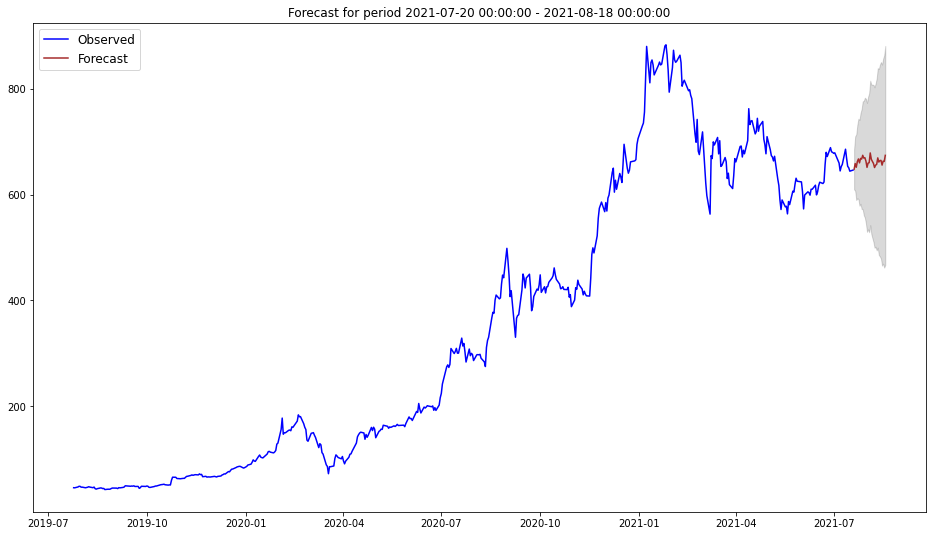

In [ ]:
############--- B.6.1 Make forecasts for "future_pred_period" ahead using the model fitted on all observed data---############
future_dates = pd.date_range(ts2.index[-1], periods = future_pred_period+1, freq=ts2.index.inferred_freq)[1:]
print(f"ORIGINAL TS: \tstarting at {ts2.index.min()} - Ending at {ts2.index.max()}")
print(f"PREDICTIONS: \tstarting at {future_dates.min()} - Ending at {future_dates.max()}")

forecast, confint = automodel.predict(n_periods=future_pred_period, return_conf_int=True)
forecast = pd.Series(forecast, index=future_dates)
IC_lower = pd.Series(confint[:, 0], index=future_dates)
IC_upper = pd.Series(confint[:, 1], index=future_dates)

############--- B.6.2 Display the plot containing observed & fitted values ---############
plt.rcParams['figure.figsize'] = [16, 9]
plt.plot(ts2, color="blue", label='Observed')
plt.plot(forecast, color='brown', label='Forecast')
plt.fill_between(IC_lower.index, IC_lower, IC_upper, color='k', alpha=.15)

plt.title(f"Forecast for period {future_dates.min()} - {future_dates.max()}")
plt.legend(loc='upper left', fontsize=12)
plt.show();

### B.7 Export Predictions

In [ ]:
#### IMPORTANT: Be sure to have the output path in your Gdrive. In this example you need to have the following structure:
#### "gdrive/My Drive/Colab Notebooks/Output/" 
f_out_name = f"{y_var}_B_ARIMA_predictions.csv"    # Choose the desired output file name

df_old_and_future = pd.concat([ts2, pd.DataFrame(forecast, index = future_dates, columns=['Prediction'])],axis=1)
df_old_and_future.to_csv(f"gdrive/My Drive/Colab Notebooks/Output/{f_out_name}")
print(f"Exported all forecasts")

Exported all forecasts
